## Initialization

In [38]:
import readout as RO
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import ode
from scipy.stats import norm
import numpy as np
from numpy import random

### - System parameters

In [39]:
g = 45e6 # Transmon-cavity coupling strength (Hz)
delta = 380e6 # Transmon-cavity detuning (0z)
chi = 2*np.pi*g**2/delta
kappa = chi

### - Simulation parameters

In [40]:
alpha_0 = 0   # Initial cavity state
t_sim = 47530e-10 # Simulation time > 20/chi
dt = 1e-10   # Simulation timestep

freq_mm = 0   # Frequency mismatch between input signal and cavity (Hz)
A = 3   # Input signal amplitude

# Input signal (square pulse)
def b_in(t):

    # Pulse start time
    t0 = 100e-9
    
    # Pulse stop time
    tf = 2500e-9
    
    if t > t0 and t < tf:
        return A*np.exp(1j*2*np.pi*freq_mm*t)

    else:
        return 0 

## Simulation

In [41]:
sim = RO.readout_simulation(b_in, freq_mm, chi, kappa, alpha_0, t_sim, dt)

### - Input signal plot

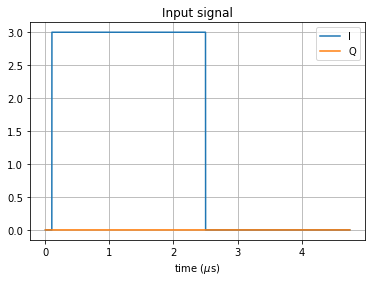

In [42]:
fig, ax = plt.subplots()
t_rng = sim.t_rng

ax.plot([t*1e6 for t in t_rng], [sim.b_in(t).real for t in t_rng], label = 'I')
ax.plot([t*1e6 for t in t_rng], [sim.b_in(t).imag for t in t_rng], label = 'Q')
ax.set_xlabel('time ($\mu$s)')
ax.set_title('Input signal')
ax.grid()
ax.legend()

plt.show()

### - Cavity state plot

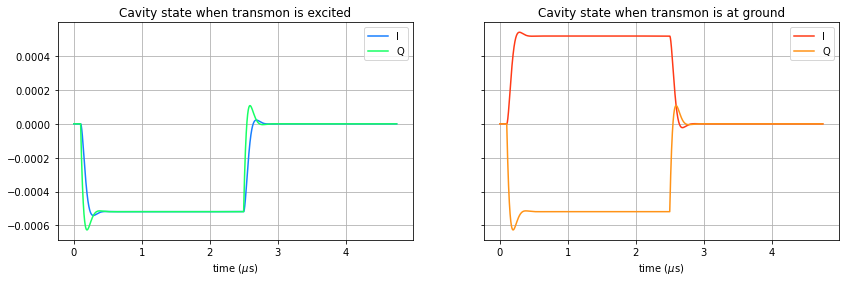

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,4))
t_rng = sim.t_rng

ax1.plot([t*1e6 for t in t_rng], [x.real for x in sim.cavity_alpha['e']], label = 'I', c = '#177FFF')
ax1.plot([t*1e6 for t in t_rng], [x.imag for x in sim.cavity_alpha['e']], label = 'Q', c = '#17FF64')
ax1.set_xlabel('time ($\mu$s)')
ax1.set_title('Cavity state when transmon is excited')
ax1.grid()
ax1.legend()

ax2.plot([t*1e6 for t in t_rng], [x.real for x in sim.cavity_alpha['g']], label = 'I', c = '#FF3A17')
ax2.plot([t*1e6 for t in t_rng], [x.imag for x in sim.cavity_alpha['g']], label = 'Q', c = '#FF9317')
ax2.set_xlabel('time ($\mu$s)')
ax2.set_title('Cavity state when transmon is at ground')
ax2.grid()
ax2.legend()

plt.show()

### - Output signal plot

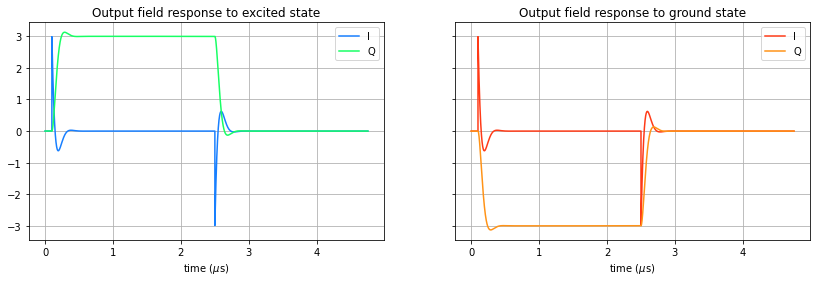

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,4))
t_rng = sim.t_rng
b_out_e = sim.b_out['e']
b_out_g = sim.b_out['g']

ax1.plot([t*1e6 for t in t_rng], [x.real for x in b_out_e], label = 'I', c = '#177FFF')
ax1.plot([t*1e6 for t in t_rng], [x.imag for x in b_out_e], label = 'Q', c = '#17FF64')
ax2.plot([t*1e6 for t in t_rng], [x.real for x in b_out_g], label = 'I', c = '#FF3A17')
ax2.plot([t*1e6 for t in t_rng], [x.imag for x in b_out_g], label = 'Q', c = '#FF9317')

ax1.set_xlabel('time ($\mu$s)')
ax1.set_title('Output field response to excited state')
ax1.grid()
ax1.legend()

ax2.set_xlabel('time ($\mu$s)')
ax2.set_title('Output field response to ground state')
ax2.grid()
ax2.legend()

plt.show()

## Noisy acquisition

In [45]:
t_wait = 5/kappa    # waiting time
t_acq = 1000e-9    # sampling time
dt_acq = 1e-9    # sampling interval

acq_b_out, proc_b_out, noisy_proc_b_out, acq_time = sim.b_signal_proc(t_wait, t_acq, dt_acq, noise = True)

### - Ouput signal plot in phase space

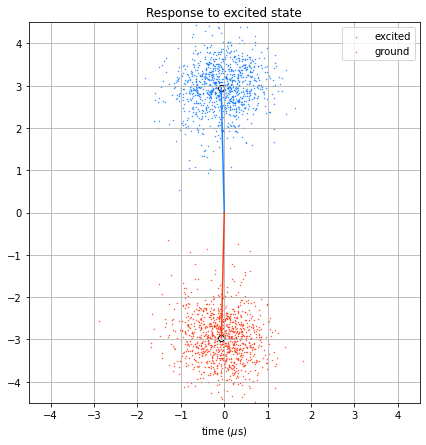

In [46]:
f, ax = plt.subplots(figsize=(7,7))
noisy_out_e = noisy_proc_b_out['e']
noisy_out_g = noisy_proc_b_out['g']

# Plot noisy data
noisy_avg_e = np.mean(noisy_out_e)
noisy_avg_g = np.mean(noisy_out_g)

ax.scatter([x.real for x in noisy_out_e], [x.imag for x in noisy_out_e], label = 'excited', c = '#177FFF', s = 0.2)
ax.scatter([x.real for x in noisy_out_g], [x.imag for x in noisy_out_g], label = 'ground', c = '#FF3A17', s = 0.2)

ax.plot([0, noisy_avg_e.real], [0, noisy_avg_e.imag], c = '#177FFF')
ax.scatter([noisy_avg_e.real], [noisy_avg_e.imag], edgecolors = 'k', c = 'w')

ax.plot([0, noisy_avg_g.real], [0, noisy_avg_g.imag], c = '#FF3A17')
ax.scatter([noisy_avg_g.real], [noisy_avg_g.imag], edgecolors = 'k', c = 'w')

ax.set_ylim([-1.5*A, 1.5*A])
ax.set_xlim([-1.5*A, 1.5*A])
ax.set_xlabel('time ($\mu$s)')
ax.set_title('Response to excited state')
ax.legend()
ax.grid()

plt.show()

## Theta estimation

In [47]:
theta_out, int_theta_out, theta_estimate = sim.theta_estimation(noisy_proc_b_out, dt_acq)

### - Plot of theta values for each acquisition

mu_e: 91.64°, std_e: 11.08°
mu_g: -91.47°, std_g: 10.94°


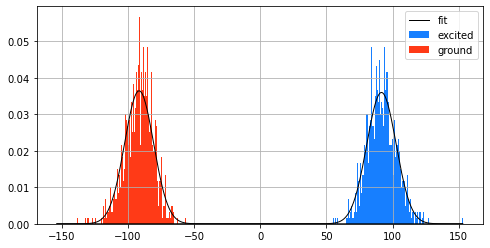

In [48]:
f, ax = plt.subplots(figsize=(8, 4))
noisy_theta_e = theta_out['e']
noisy_theta_g = theta_out['g']

# Fit data to normal distribution
mu_e, std_e = norm.fit(noisy_theta_e)
mu_g, std_g = norm.fit(noisy_theta_g)

binwidth = 0.6
lim_min = np.ceil(np.array(noisy_theta_e + noisy_theta_g).min() / binwidth) * binwidth
lim_max = np.ceil(np.array(noisy_theta_e + noisy_theta_g).max() / binwidth) * binwidth
bins = np.arange(lim_min, lim_max + binwidth, binwidth)

ax.hist(noisy_theta_e, density=True, color = '#177FFF', bins=bins, label = 'excited')
ax.hist(noisy_theta_g, density=True, color = '#FF3A17', bins=bins, label = 'ground')

x = np.linspace(lim_min, lim_max, 500)
p_e = norm.pdf(x, mu_e, std_e)
plt.plot(x, p_e, 'k', linewidth=1., label = 'fit')
p_g = norm.pdf(x, mu_g, std_g)
plt.plot(x, p_g, 'k', linewidth=1.)

print('mu_e: %.2f°, std_e: %.2f°' % (mu_e, std_e))
print('mu_g: %.2f°, std_g: %.2f°' % (mu_g, std_g))

plt.legend()
plt.grid()
plt.show()

### - Theta estimation

In [31]:
print('ground state: ', theta_estimate['g'])
print('excited state: ', theta_estimate['e'])

ground state:  -103.4623883891188
excited state:  91.33517338890448


## Running multiple readouts

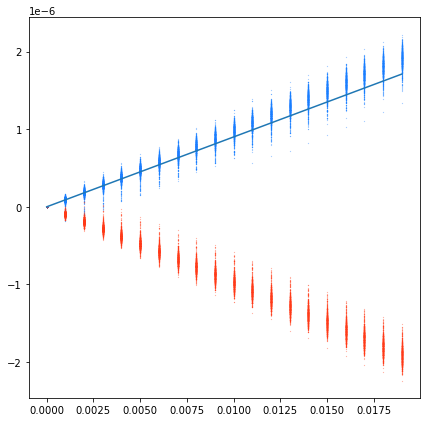

In [51]:
'''
Readout parameters
'''

g = 45e6 # Transmon-cavity coupling strength (Hz)
delta = 380e6 # Transmon-cavity detuning (0z)
chi = 2*np.pi*g**2/delta
kappa = chi

alpha_0 = 0   # Initial cavity state
t_sim = 47530e-10 # Simulation time > 20/chi
dt = 1e-10   # Simulation timestep

freq_mm = 0   # Frequency mismatch between input signal and cavity (Hz)
A = 3   # Input signal amplitude

# Input signal (square pulse)
def b_in(t):

    # Pulse start time
    t0 = 100e-9
    
    # Pulse stop time
    tf = 2500e-9
    
    if t > t0 and t < tf:
        return A*np.exp(1j*2*np.pi*freq_mm*t)

    else:
        return 0 

t_wait = 5/kappa    # waiting time
t_acq = 20e-9    # sampling time
dt_acq = 1e-9    # sampling interval

'''
Simulation
'''

sim = RO.readout_simulation(b_in, freq_mm, chi, kappa, alpha_0, t_sim, dt)

f, ax = plt.subplots(figsize=(7,7))

# Plot measured theta for N runs as a function of measurement time
N = 1000
for n in range(N):
    acq_b_out, proc_b_out, noisy_proc_b_out, acq_time = sim.b_signal_proc(t_wait, t_acq, dt_acq, noise = True)
    theta_out, int_theta_out, theta_estimate = sim.theta_estimation(noisy_proc_b_out, dt_acq)
    int_theta_e = int_theta_out['e']
    int_theta_g = int_theta_out['g']

    acq_N = len(int_theta_e)
    ax.scatter([dt_acq*1e6*i for i in range(acq_N)], int_theta_e, label = 'excited', c = '#177FFF', s = 0.02)
    ax.scatter([dt_acq*1e6*i for i in range(acq_N)], int_theta_g, label = 'ground', c = '#FF3A17', s = 0.02)

# Expected values of theta depending on the transmon state. Assumes b_in is a single-frequency pulse. 
# The calculation is performed using the reflection coefficient. 
exp_theta = {'g': np.angle((-1j*sim.chi - sim.kappa)/(-1j*sim.chi + sim.kappa), deg = True),
             'e': np.angle((1j*sim.chi - sim.kappa)/(1j*sim.chi + sim.kappa), deg = True)}

# Plot theoretical expected values of integrated theta
plt.plot([dt_acq*1e6*i for i in range(acq_N)], [exp_theta['e']*dt_acq*i for i in range(acq_N)])

plt.show()
